<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/problem2_qiskit_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [120]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install numpy
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-aer

In [121]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [122]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-skku/hackathon-2024/hackathon',
    token='24ce54238a7bb29fe5e3eb450acefed2444169ce5e525f08f9515676b1cf257ea65b85895d4157a30359eb3d9a4aab9873008d7edf6ff177ed29015e625e4ad6'
)

In [123]:
backend = AerSimulator()
print(backend)

AerSimulator('aer_simulator')


In [124]:
num_qubits = 5

# 1. 그냥

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

## ansatz

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

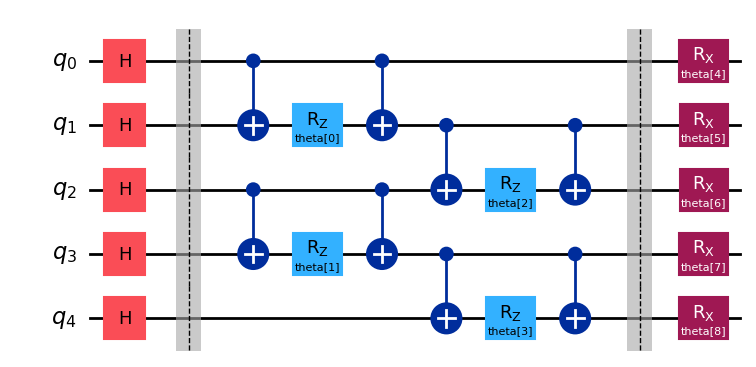

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

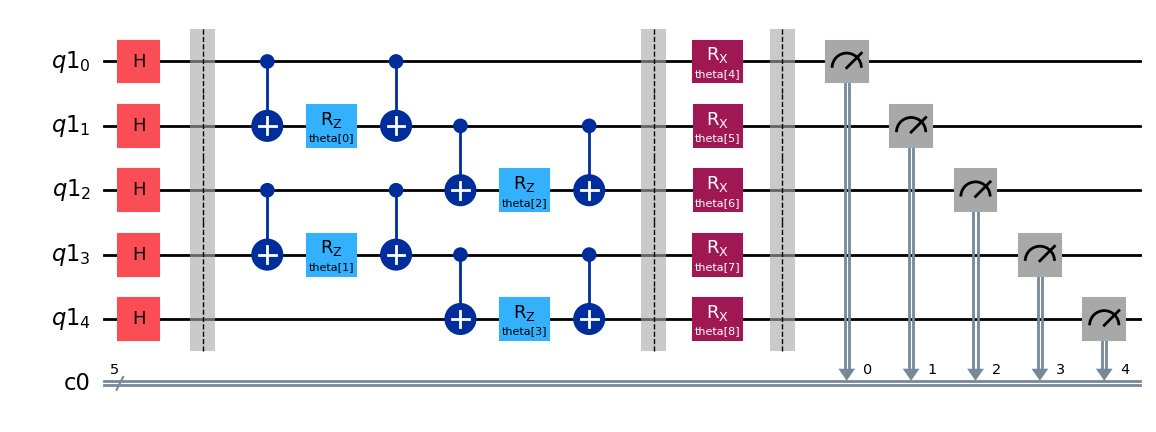

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

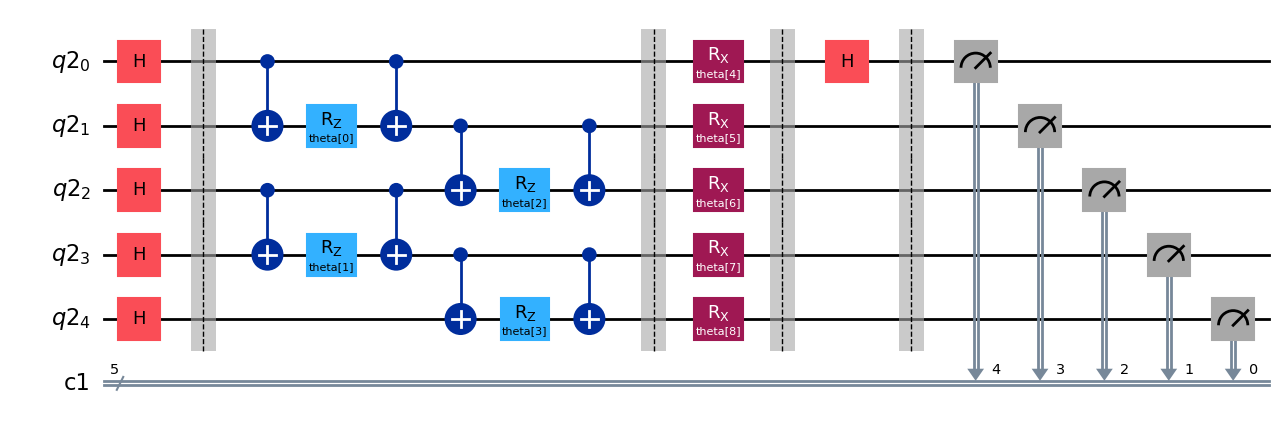

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

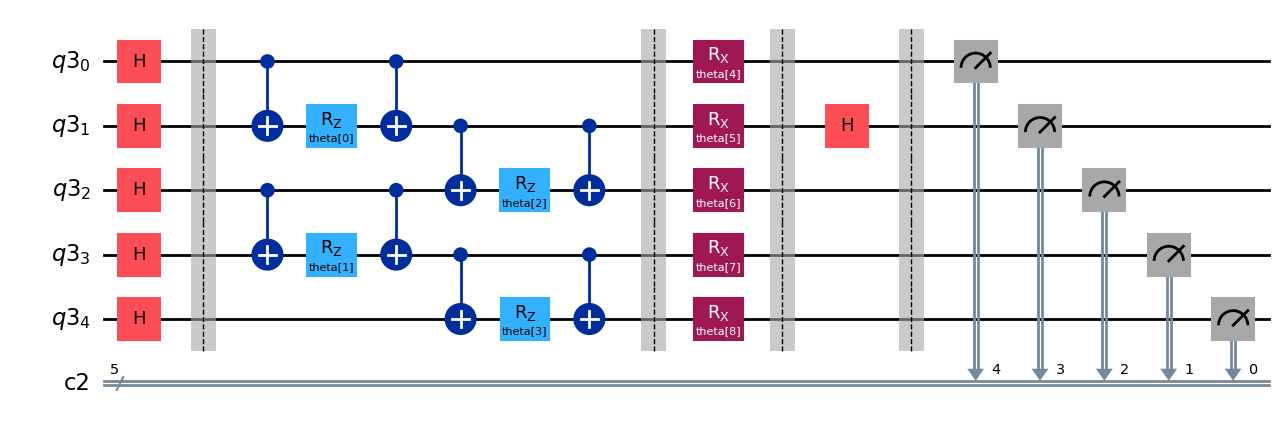

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

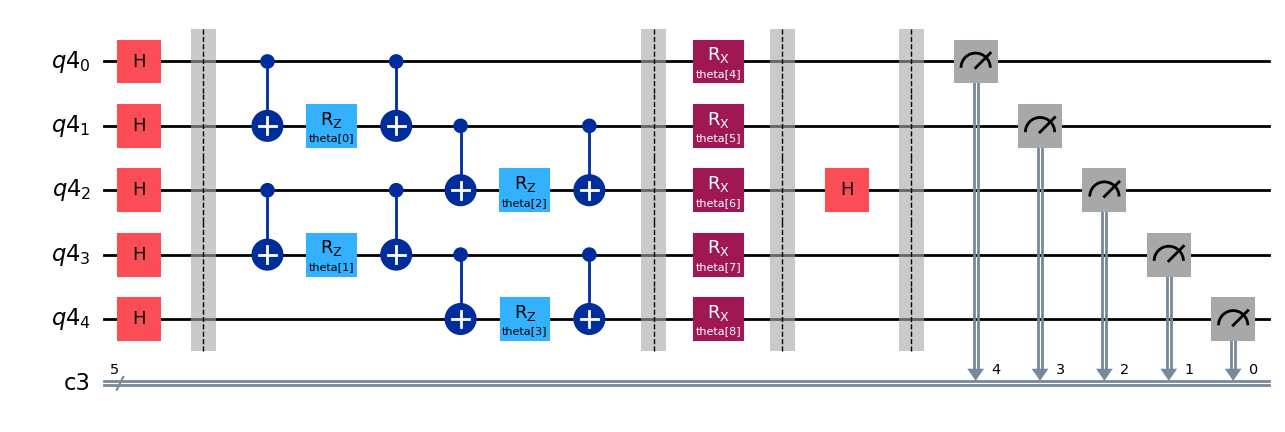

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

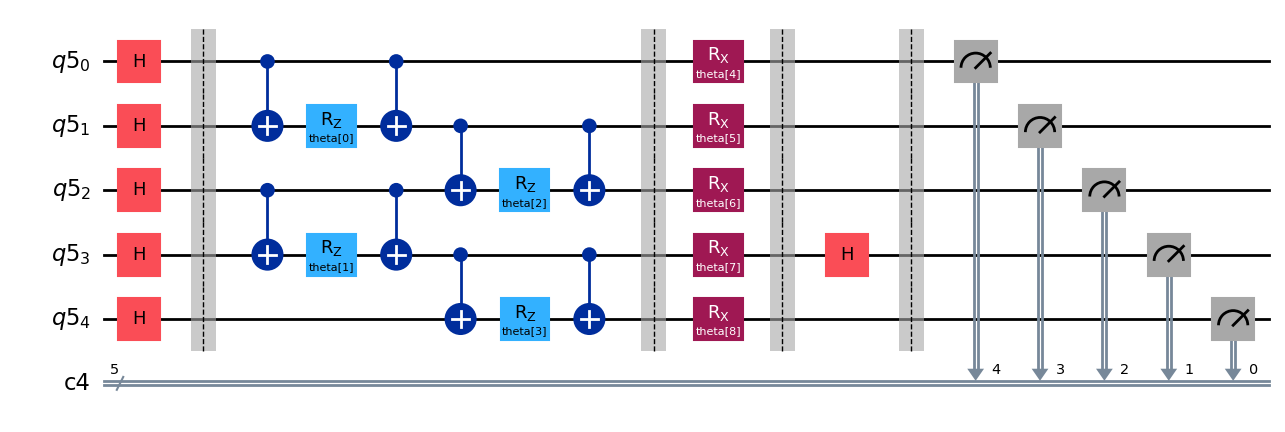

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

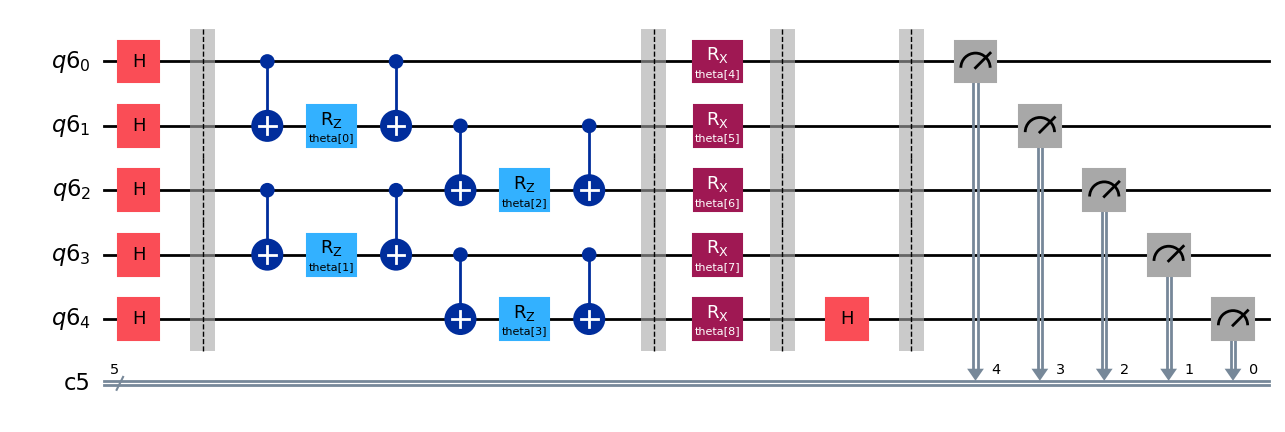

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [ ]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## cost function

In [ ]:
def ZZ(ansatz_zz, params_pqc, sampler, shots):
  job = sampler.run(ansatz_zz, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]
    else:
      expval = expval - prob_string[k]

  return expval

In [ ]:
def X0(ansatz_x0, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x0, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt

  return expval


def X1(ansatz_x1, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x1, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  return expval


def X2(ansatz_x2, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x2, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  return expval


def X3(ansatz_x3, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x3, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])
    expval = expval + (prob_string[k+1] - prob_string[k+3])

  return expval


def X4(ansatz_x4, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x4, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])

  return expval

In [ ]:
def cost_func_vqe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots):
  expval = 0
  expval = expval + ZZ(ansatz_zz, params_pqc, sampler, shots)
  expval = expval - X0(ansatz_x0, params_pqc, sampler, shots)
  expval = expval - X1(ansatz_x1, params_pqc, sampler, shots)
  expval = expval - X2(ansatz_x2, params_pqc, sampler, shots)
  expval = expval - X3(ansatz_x3, params_pqc, sampler, shots)
  expval = expval - X4(ansatz_x4, params_pqc, sampler, shots)

  return expval

In [ ]:
shots = 1000

cost_func_vqe(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots)

-5.884000000000001

In [ ]:
def build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])

x0

array([5.803e+00, 5.886e+00, 5.886e+00, 5.803e+00, 7.854e+00, 1.823e-07,
       7.854e+00, 1.749e-06, 1.571e+00])

In [ ]:
shots = 50
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.772
0.5209836849652784


In [ ]:
shots = 250
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.828
0.3568573944869295


In [ ]:
shots = 500
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.7392
0.2579128534990067


In [ ]:
shots = 750
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.8792
0.19418094654213586


In [ ]:
shots = 1000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.888200000000001
0.17034036515165718


In [ ]:
shots = 2000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.880733333333334
0.1547022372890002


In [ ]:
shots = 5000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.881
0.14154422630400695


# 2. Classical Shadow (Randomized Clifford Gates) 5Q

In [ ]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate

## ansatz and classical shadow

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

def circuit_base(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

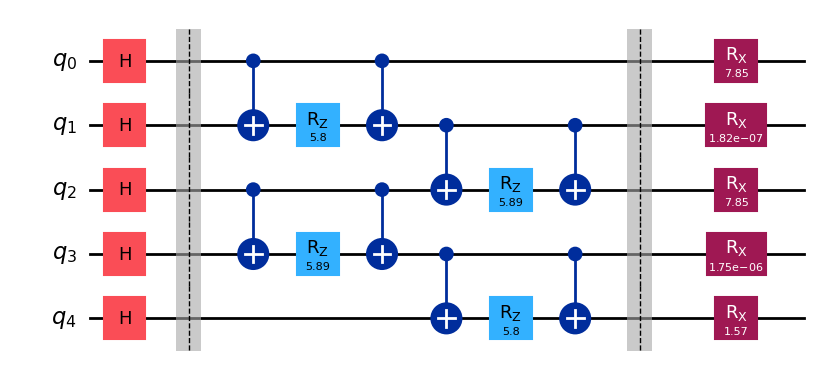

In [ ]:
%matplotlib inline

params = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])
qc = circuit_base(params, num_qubits)
qc.draw("mpl")

In [ ]:
pauli_list = [
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

In [ ]:
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

In [ ]:
def cluster_rho(num_qubits, qc, size):

  reps = 1

  Cluster_Size = size
  cliffords = [qiskit.quantum_info.random_clifford(num_qubits) for _ in range(Cluster_Size)]

  results = []
  for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
    results.append(counts)

  shadows = []
  for cliff, res in zip(cliffords, results):
    mat = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(num_qubits,np.outer(Ub,Ub.conj()))*count)

  return np.sum(shadows,axis=0)/(Cluster_Size)

In [ ]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [ ]:
list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  +[SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)])

In [ ]:
def clustor_observable(num_qubits, qc, size, list_of_observables):
  lst = []
  for o in list_of_observables:
    rho = cluster_rho(num_qubits, qc, size)
    o_matrix = o.to_matrix()
    lst.append(np.real(np.trace(np.matmul(rho, o_matrix))))

  lst = np.array(lst)

  return lst

In [ ]:
qc = circuit_base(params, num_qubits)
print(clustor_observable(num_qubits, qc, 200, list_of_observables))

[-4.95000000e-01 -4.95000000e-01 -1.65000000e-01 -1.65000000e-01
  8.25000000e-01  6.60000000e-01  1.48500000e+00  8.25000000e-01
  2.49800181e-16]


In [ ]:
def mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, size=200):
  qc = circuit_base(params, num_qubits)
  median_list = []

  sum = 0

  observable_list = []
  for i in range(shadow_size//200):
    observable_list.append(clustor_observable(num_qubits, qc, 200, list_of_observables))

  for j in range(9):
    med = np.median(np.array([observable_list[i][j] for i in range(shadow_size//200)]))

    if j<4:
      sum = sum + med

    else:
      sum = sum - med

  return sum

## cost function

In [ ]:
def cost_func_clifford_shadow(params, shadow_size):
  num_qubits = 5
  list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  +[SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)])
  return mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, 200)

In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 200))

-5.609999999999992
-5.609999999999992
-5.279999999999991
-5.279999999999991
-11.219999999999986
-11.219999999999986
-5.279999999999992
-5.279999999999992
-5.609999999999991
-5.609999999999991
-3.299999999999995
-3.299999999999995
-3.2999999999999954
-3.2999999999999954
-5.93999999999999
-5.93999999999999
-6.269999999999992
-6.269999999999992
-4.289999999999994
-4.289999999999994


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 250))

-5.675999999999993
-5.675999999999993
-4.883999999999997
-4.883999999999997
-6.071999999999996
-6.071999999999996
-8.579999999999995
-8.579999999999995
-6.467999999999992
-6.467999999999992
-6.335999999999992
-6.335999999999992
-6.467999999999996
-6.467999999999996
-6.203999999999992
-6.203999999999992
-4.091999999999993
-4.091999999999993
-7.655999999999993
-7.655999999999993


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 500))

-4.421999999999995
-4.421999999999995
-7.127999999999994
-7.127999999999994
-6.138000000000002
-6.138000000000002
-6.929999999999998
-6.929999999999998
-4.949999999999996
-4.949999999999996
-6.8639999999999946
-6.8639999999999946
-5.741999999999994
-5.741999999999994
-6.4019999999999975
-6.4019999999999975
-5.214
-5.214
-6.665999999999997
-6.665999999999997


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 750))

-6.512000000000002
-6.512000000000002
-5.280000000000004
-5.280000000000004
-5.412000000000003
-5.412000000000003
-6.072000000000001
-6.072000000000001
-5.808000000000001
-5.808000000000001
-4.532000000000003
-4.532000000000003
-6.028
-6.028
-6.556000000000001
-6.556000000000001
-6.731999999999996
-6.731999999999996
-4.928000000000004
-4.928000000000004


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 1000))

-5.016000000000002
-5.016000000000002
-5.808000000000004
-5.808000000000004
-5.247000000000005
-5.247000000000005
-5.610000000000006
-5.610000000000006
-6.204000000000002
-6.204000000000002
-6.237
-6.237
-6.930000000000005
-6.930000000000005
-6.171000000000002
-6.171000000000002
-5.907000000000003
-5.907000000000003
-6.336000000000001
-6.336000000000001


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 2000))

-6.517500000000012
-6.517500000000012
-5.49450000000001
-5.49450000000001
-5.907000000000008
-5.907000000000008
-6.303000000000004
-6.303000000000004
-5.973000000000006
-5.973000000000006
-6.3855000000000075
-6.3855000000000075
-6.138000000000009
-6.138000000000009
-5.824500000000005
-5.824500000000005
-6.055500000000013
-6.055500000000013
-5.973000000000011
-5.973000000000011


In [ ]:
lst = [-5.609999999999992,
-5.279999999999991,
-11.219999999999986,
-5.279999999999992,
-5.609999999999991,
-3.299999999999995,
-3.2999999999999954,
-5.93999999999999,
-6.269999999999992,
-4.289999999999994]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-5.675999999999993,
-4.883999999999997
-6.071999999999996
-8.579999999999995,
-6.467999999999992,
-6.335999999999992,
-6.467999999999996,
-6.203999999999992,
-4.091999999999993,
-7.655999999999993]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-4.421999999999995,
-7.127999999999994,
-6.138000000000002,
-6.929999999999998,
-4.949999999999996,
-6.8639999999999946,
-5.741999999999994,
-6.4019999999999975,
-5.214,
-6.665999999999997]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-6.512000000000002,
-5.280000000000004,
-5.412000000000003,
-6.072000000000001,
-5.808000000000001,
-4.532000000000003,
-6.028,
-6.556000000000001,
-6.731999999999996,
-4.928000000000004]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-5.016000000000002,
-5.808000000000004,
-5.247000000000005,
-5.610000000000006,
-6.204000000000002,
-6.237,
-6.930000000000005,
-6.171000000000002,
-5.907000000000003,
-6.336000000000001]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-6.517500000000012,
-5.49450000000001,
-5.907000000000008,
-6.303000000000004,
-5.973000000000006,
-6.3855000000000075,
-6.138000000000009,
-5.824500000000005,
-6.055500000000013,
-5.973000000000011]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()

-5.609999999999991
2.113030998352838

-7.804499999999992
4.531195620363348

-6.045599999999996
0.8811432573651118

-5.786000000000002
0.697160526708159

-5.946600000000003
0.5300173959409255

-6.057150000000009
0.2818024174843076



In [ ]:
lst = [-5.016000000000002,
-5.808000000000004,
-5.247000000000005,
-5.610000000000006,
-6.204000000000002,
-6.237,
-6.930000000000005,
-6.171000000000002,
-5.907000000000003,
-6.336000000000001]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

# 3. Variation 5Q

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

## ansatz

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(10)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX", "YIIII", "IYIII", "IIYII", "IIIYI", "IIIIY"]
hamiltonian_list = []
for i in range(14):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-7.7888544030534606

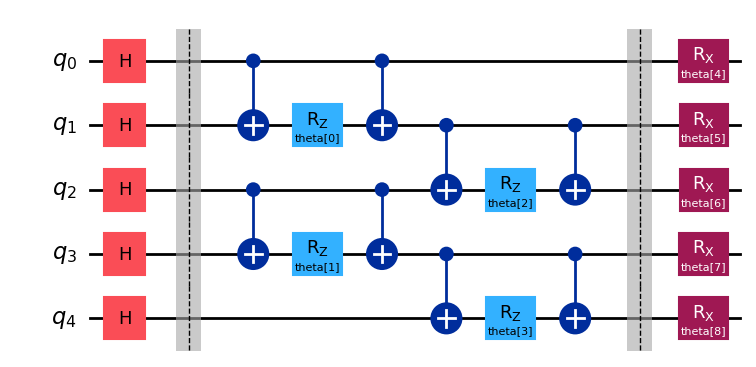

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

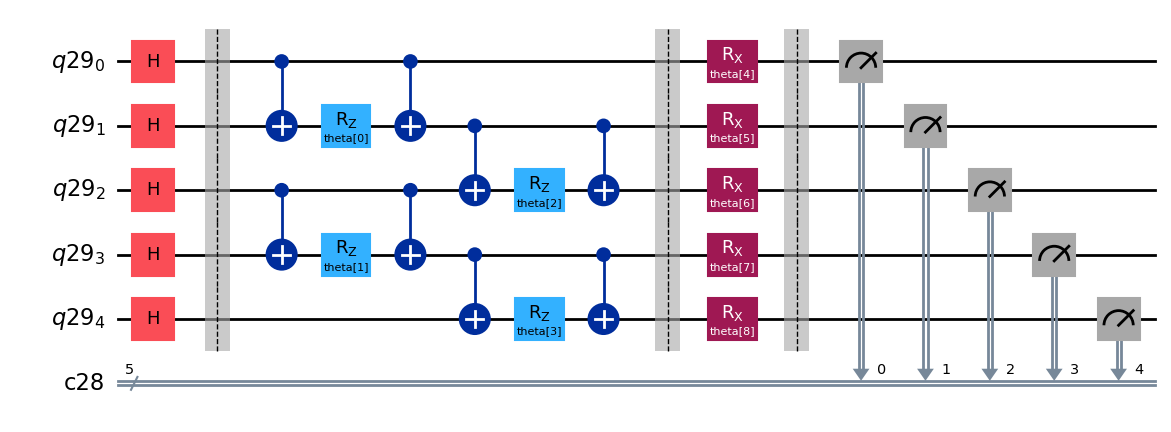

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

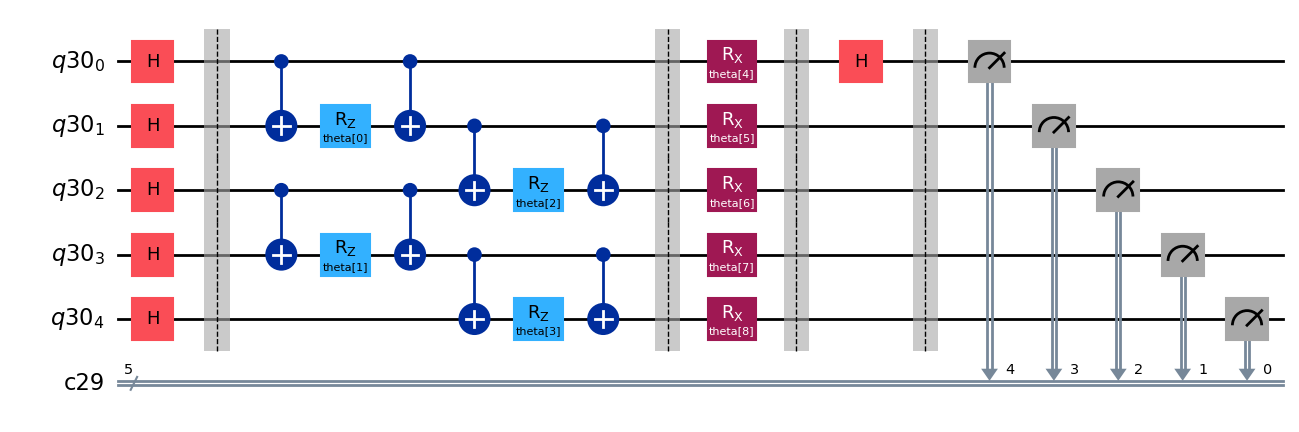

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

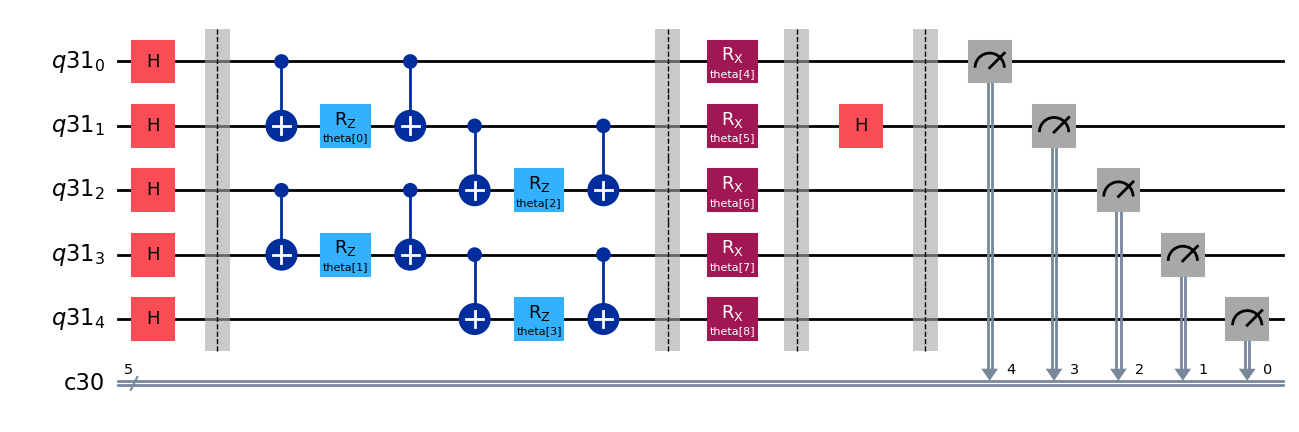

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

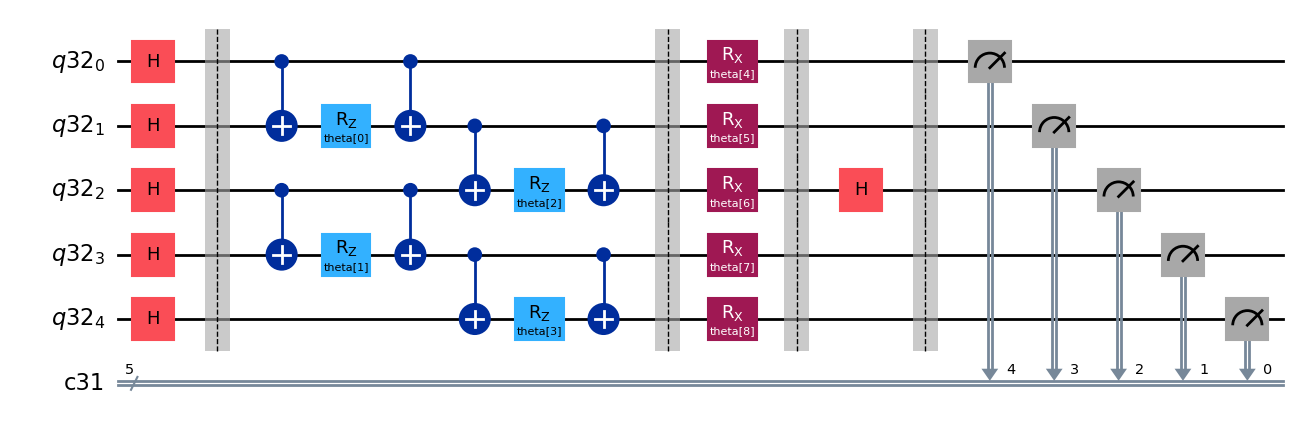

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

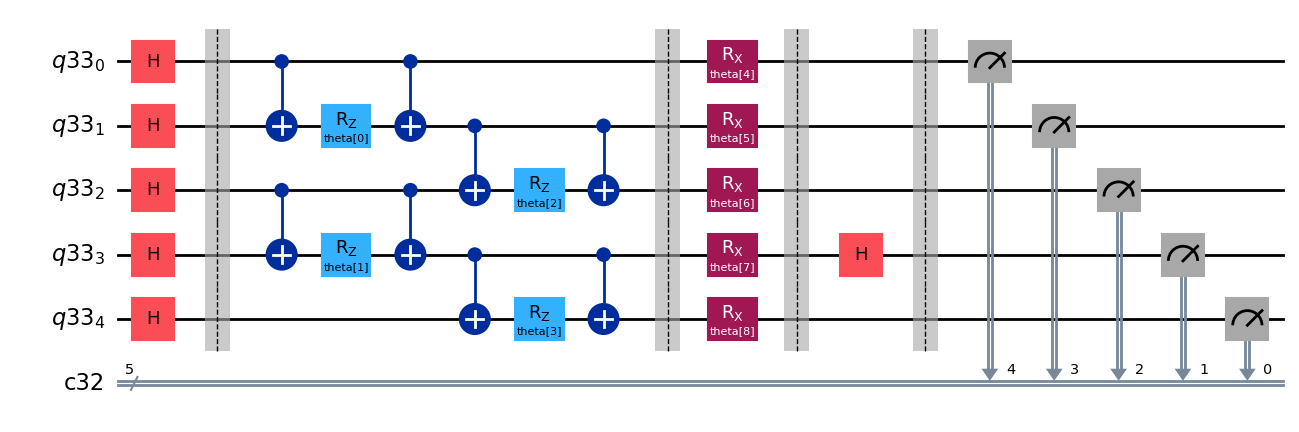

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

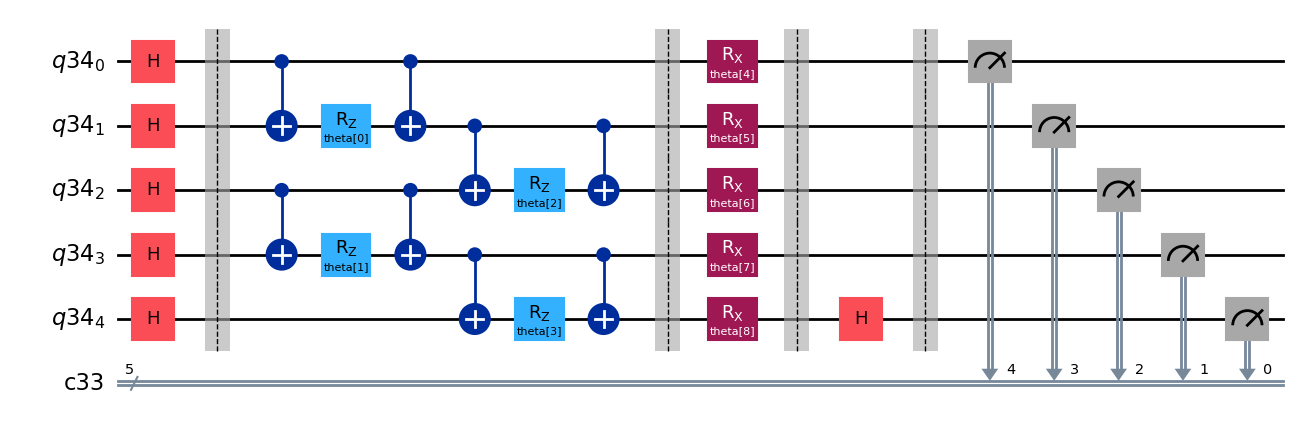

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

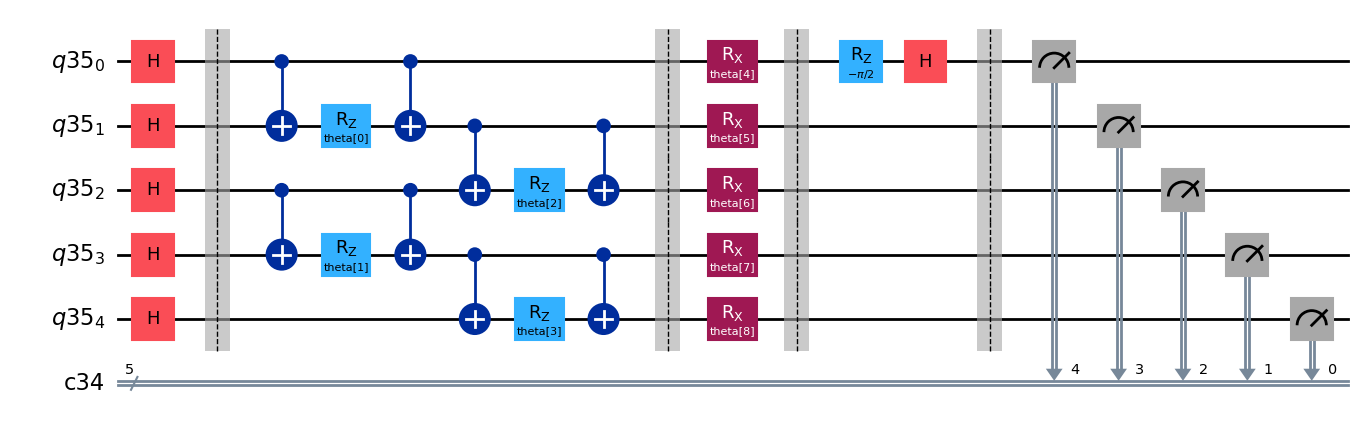

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_y0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_y0.h(range(0,5))

ansatz_y0.barrier()

ansatz_y0.cx(0, 1)
ansatz_y0.cx(2, 3)
ansatz_y0.rz(next(it), 1)
ansatz_y0.rz(next(it), 3)
ansatz_y0.cx(0, 1)
ansatz_y0.cx(2, 3)
ansatz_y0.cx(1, 2)
ansatz_y0.cx(3, 4)
ansatz_y0.rz(next(it), 2)
ansatz_y0.rz(next(it), 4)
ansatz_y0.cx(1, 2)
ansatz_y0.cx(3, 4)

ansatz_y0.barrier()

ansatz_y0.rx(next(it), 0)
ansatz_y0.rx(next(it), 1)
ansatz_y0.rx(next(it), 2)
ansatz_y0.rx(next(it), 3)
ansatz_y0.rx(next(it), 4)

ansatz_y0.barrier()

ansatz_y0.rz(-np.pi/2, 0)
ansatz_y0.h(0)

ansatz_y0.barrier()

ansatz_y0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_y0.draw("mpl")

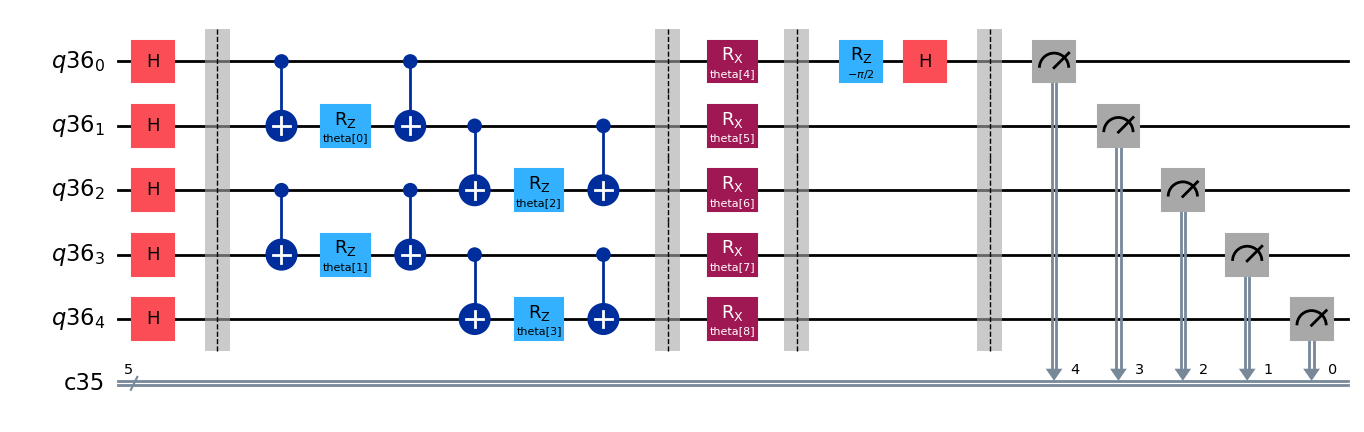

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_y1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_y1.h(range(0, 5))

ansatz_y1.barrier()

ansatz_y1.cx(0, 1)
ansatz_y1.cx(2, 3)
ansatz_y1.rz(next(it), 1)
ansatz_y1.rz(next(it), 3)
ansatz_y1.cx(0, 1)
ansatz_y1.cx(2, 3)
ansatz_y1.cx(1, 2)
ansatz_y1.cx(3, 4)
ansatz_y1.rz(next(it), 2)
ansatz_y1.rz(next(it), 4)
ansatz_y1.cx(1, 2)
ansatz_y1.cx(3, 4)

ansatz_y1.barrier()

ansatz_y1.rx(next(it), 0)
ansatz_y1.rx(next(it), 1)
ansatz_y1.rx(next(it), 2)
ansatz_y1.rx(next(it), 3)
ansatz_y1.rx(next(it), 4)

ansatz_y1.barrier()

ansatz_y1.rz(-np.pi/2, 0)
ansatz_y1.h(0)

ansatz_y1.barrier()

ansatz_y1.measure([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])

ansatz_y1.draw("mpl")


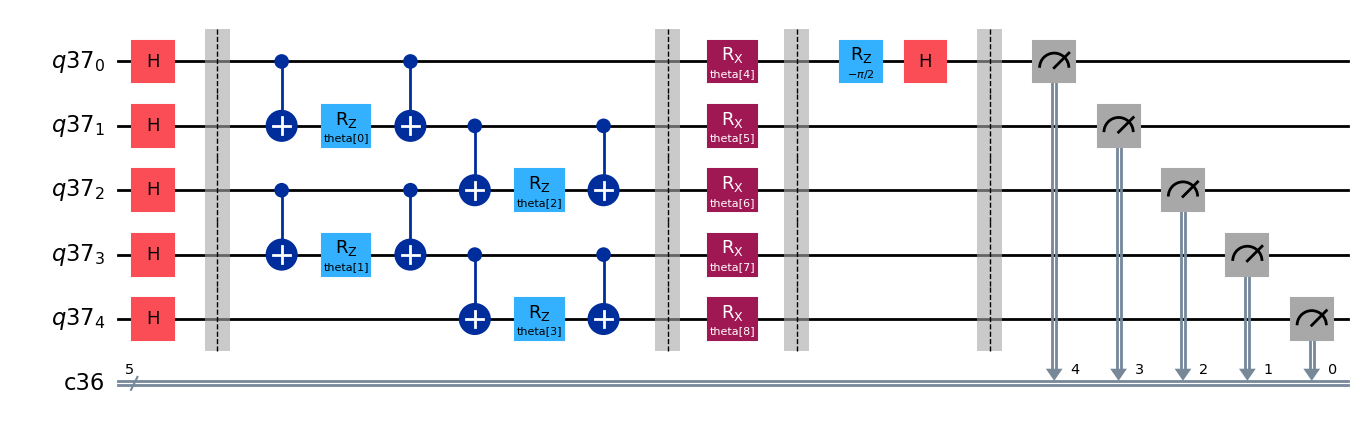

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_y2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_y2.h(range(0, 5))

ansatz_y2.barrier()

ansatz_y2.cx(0, 1)
ansatz_y2.cx(2, 3)
ansatz_y2.rz(next(it), 1)
ansatz_y2.rz(next(it), 3)
ansatz_y2.cx(0, 1)
ansatz_y2.cx(2, 3)
ansatz_y2.cx(1, 2)
ansatz_y2.cx(3, 4)
ansatz_y2.rz(next(it), 2)
ansatz_y2.rz(next(it), 4)
ansatz_y2.cx(1, 2)
ansatz_y2.cx(3, 4)

ansatz_y2.barrier()

ansatz_y2.rx(next(it), 0)
ansatz_y2.rx(next(it), 1)
ansatz_y2.rx(next(it), 2)
ansatz_y2.rx(next(it), 3)
ansatz_y2.rx(next(it), 4)

ansatz_y2.barrier()

ansatz_y2.rz(-np.pi/2, 0)
ansatz_y2.h(0)

ansatz_y2.barrier()

ansatz_y2.measure([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])

ansatz_y2.draw("mpl")


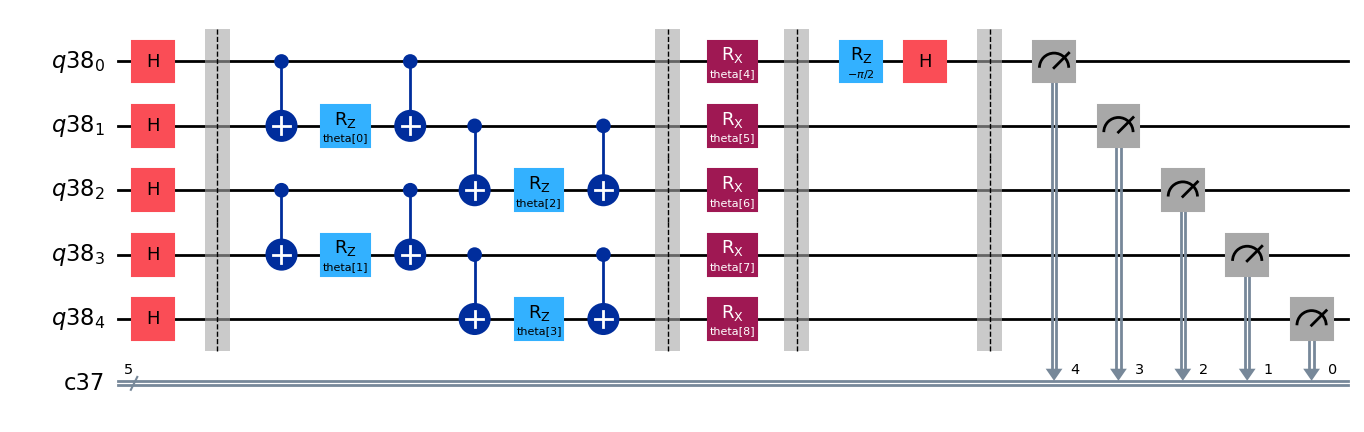

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_y3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_y3.h(range(0, 5))

ansatz_y3.barrier()

ansatz_y3.cx(0, 1)
ansatz_y3.cx(2, 3)
ansatz_y3.rz(next(it), 1)
ansatz_y3.rz(next(it), 3)
ansatz_y3.cx(0, 1)
ansatz_y3.cx(2, 3)
ansatz_y3.cx(1, 2)
ansatz_y3.cx(3, 4)
ansatz_y3.rz(next(it), 2)
ansatz_y3.rz(next(it), 4)
ansatz_y3.cx(1, 2)
ansatz_y3.cx(3, 4)

ansatz_y3.barrier()

ansatz_y3.rx(next(it), 0)
ansatz_y3.rx(next(it), 1)
ansatz_y3.rx(next(it), 2)
ansatz_y3.rx(next(it), 3)
ansatz_y3.rx(next(it), 4)

ansatz_y3.barrier()

ansatz_y3.rz(-np.pi/2, 0)
ansatz_y3.h(0)

ansatz_y3.barrier()

ansatz_y3.measure([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])

ansatz_y3.draw("mpl")


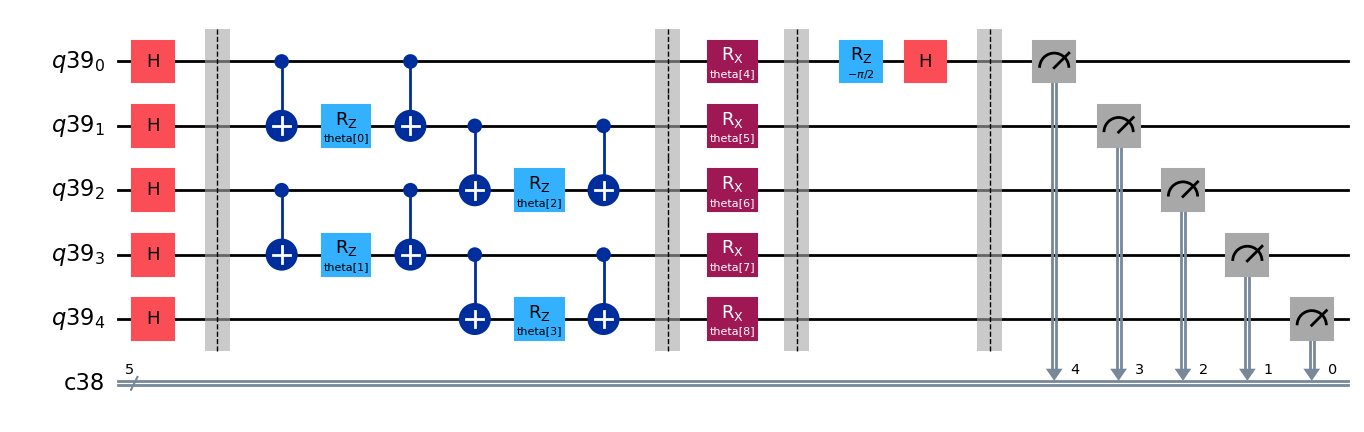

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_y4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_y4.h(range(0, 5))

ansatz_y4.barrier()

ansatz_y4.cx(0, 1)
ansatz_y4.cx(2, 3)
ansatz_y4.rz(next(it), 1)
ansatz_y4.rz(next(it), 3)
ansatz_y4.cx(0, 1)
ansatz_y4.cx(2, 3)
ansatz_y4.cx(1, 2)
ansatz_y4.cx(3, 4)
ansatz_y4.rz(next(it), 2)
ansatz_y4.rz(next(it), 4)
ansatz_y4.cx(1, 2)
ansatz_y4.cx(3, 4)

ansatz_y4.barrier()

ansatz_y4.rx(next(it), 0)
ansatz_y4.rx(next(it), 1)
ansatz_y4.rx(next(it), 2)
ansatz_y4.rx(next(it), 3)
ansatz_y4.rx(next(it), 4)

ansatz_y4.barrier()

ansatz_y4.rz(-np.pi/2, 0)
ansatz_y4.h(0)

ansatz_y4.barrier()

ansatz_y4.measure([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])

ansatz_y4.draw("mpl")


In [ ]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## cost function

In [ ]:
def ZZ(ansatz_zz, params_pqc, sampler, shots):
  job = sampler.run(ansatz_zz, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]
    else:
      expval = expval - prob_string[k]

  return expval

In [ ]:
def X0(ansatz_x0, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x0, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt

  return expval


def X1(ansatz_x1, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x1, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  return expval


def X2(ansatz_x2, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x2, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  return expval


def X3(ansatz_x3, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x3, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])
    expval = expval + (prob_string[k+1] - prob_string[k+3])

  return expval


def X4(ansatz_x4, params_pqc, sampler, shots):
  job = sampler.run(ansatz_x4, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])

  return expval

In [ ]:
def Y0(ansatz_y0, params_pqc, sampler, shots):
  job = sampler.run(ansatz_y0, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt

  return expval


def Y1(ansatz_y1, params_pqc, sampler, shots):
  job = sampler.run(ansatz_y1, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt

  return expval


def Y2(ansatz_y2, params_pqc, sampler, shots):
  job = sampler.run(ansatz_y2, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt

  return expval


def Y3(ansatz_y3, params_pqc, sampler, shots):
  job = sampler.run(ansatz_y3, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])
    expval = expval + (prob_string[k+1] - prob_string[k+3])

  return expval


def Y4(ansatz_y4, params_pqc, sampler, shots):
  job = sampler.run(ansatz_y4, params_pqc, shots=shots).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])

  return expval

In [ ]:
def cost_func_vqe(params_pqc, sampler, shots):
  expval = 0
  expval = expval + ZZ(ansatz_zz, params_pqc, sampler, shots)
  expval = expval - X0(ansatz_x0, params_pqc, sampler, shots)
  expval = expval - X1(ansatz_x1, params_pqc, sampler, shots)
  expval = expval - X2(ansatz_x2, params_pqc, sampler, shots)
  expval = expval - X3(ansatz_x3, params_pqc, sampler, shots)
  expval = expval - X4(ansatz_x4, params_pqc, sampler, shots)
  expval = expval - Y0(ansatz_y0, params_pqc, sampler, shots)
  expval = expval - Y1(ansatz_y1, params_pqc, sampler, shots)
  expval = expval - Y2(ansatz_y2, params_pqc, sampler, shots)
  expval = expval - Y3(ansatz_y3, params_pqc, sampler, shots)
  expval = expval - Y4(ansatz_y4, params_pqc, sampler, shots)

  return expval

In [ ]:
shots = 100

cost_func_vqe(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), sampler, shots)

-5.459999999999999

In [ ]:
def build_callback_vqe(sampler, shots, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, sampler, shots)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])

x0

array([5.803e+00, 5.886e+00, 5.886e+00, 5.803e+00, 7.854e+00, 1.823e-07,
       7.854e+00, 1.749e-06, 1.571e+00])

In [ ]:
shots = 10
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.18
1.8282231811242302


In [ ]:
shots = 25
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.408
1.9427979822925496


In [ ]:
shots = 50
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.652
0.7539124617619738


In [ ]:
shots = 75
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.725333333333333
0.8137660051336074


In [ ]:
shots = 100
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.470000000000001
0.3761914406256474


In [ ]:
shots = 200
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.740000000000001
0.6989706717738595


In [ ]:
shots = 500
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.783600000000002
0.2938832421217656


# 4. Variation Classical Shadow (Randomized Clifford Gates) 5Q

In [ ]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate

## ansatz and classical shadow

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(10)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX", "YIIII", "IYIII", "IIYII", "IIIYI", "IIIIY"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

def circuit_base(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

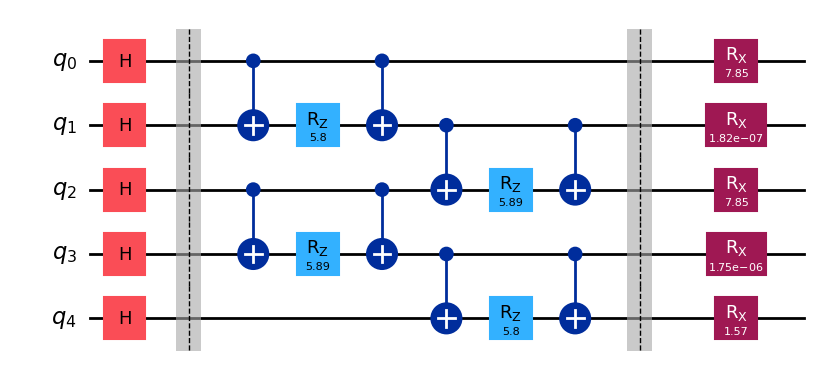

In [ ]:
%matplotlib inline
num_qubits = 5
params = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])
qc = circuit_base(params, num_qubits)
qc.draw("mpl")

In [ ]:
pauli_list = [
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

In [ ]:
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

In [ ]:
def cluster_rho(num_qubits, qc, size):

  reps = 1

  Cluster_Size = size
  cliffords = [qiskit.quantum_info.random_clifford(num_qubits) for _ in range(Cluster_Size)]

  results = []
  for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
    results.append(counts)

  shadows = []
  for cliff, res in zip(cliffords, results):
    mat = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(num_qubits,np.outer(Ub,Ub.conj()))*count)

  return np.sum(shadows,axis=0)/(Cluster_Size)

In [ ]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [ ]:
list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  + [SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)] + [SparsePauliOp(generate_pauli_string([i],["Y"], num_qubits)) for i in range(num_qubits)])

In [ ]:
def clustor_observable(num_qubits, qc, size, list_of_observables):
  lst = []
  for o in list_of_observables:
    rho = cluster_rho(num_qubits, qc, size)
    o_matrix = o.to_matrix()
    lst.append(np.real(np.trace(np.matmul(rho, o_matrix))))

  lst = np.array(lst)

  return lst

In [ ]:
def mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, size=200):
  qc = circuit_base(params, num_qubits)
  median_list = []

  sum = 0

  observable_list = []
  for i in range(shadow_size//200):
    observable_list.append(clustor_observable(num_qubits, qc, 200, list_of_observables))

  for j in range(9):
    med = np.median(np.array([observable_list[i][j] for i in range(shadow_size//200)]))

    if j<4:
      sum = sum + med

    else:
      sum = sum - med

  return sum

## cost function

In [ ]:
def cost_func_clifford_shadow(params, shadow_size):
  num_qubits = 5
  list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  + [SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)] + [SparsePauliOp(generate_pauli_string([i],["Y"], num_qubits)) for i in range(num_qubits)])
  return mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, 200)

In [ ]:
shots = 200

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 400

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 600

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 800

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 1000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 2000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

In [ ]:
shots = 5000

lst = []
for _ in range(10):
  lst.append(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), shots))

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

# 5. 그냥 Backend

In [125]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

In [126]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeOsaka
from qiskit.visualization import plot_histogram

# Generate a 5-qubit simulated backend
backend = FakeOsaka()

## ansatz

In [128]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

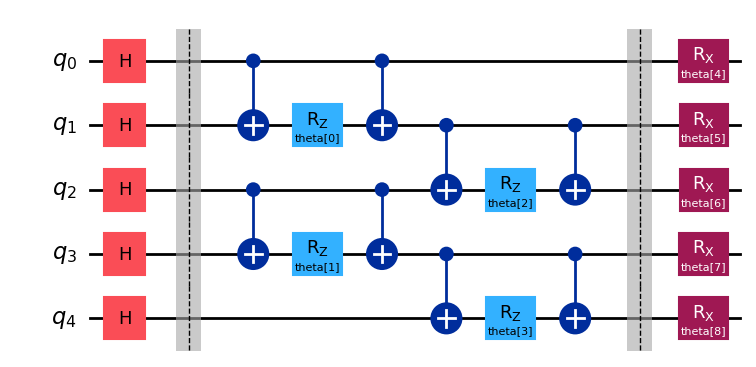

In [129]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

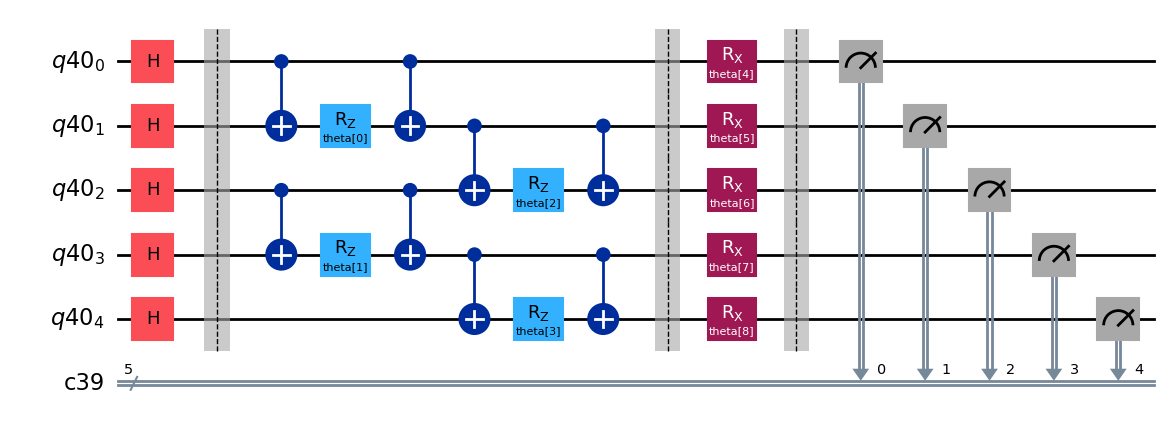

In [130]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

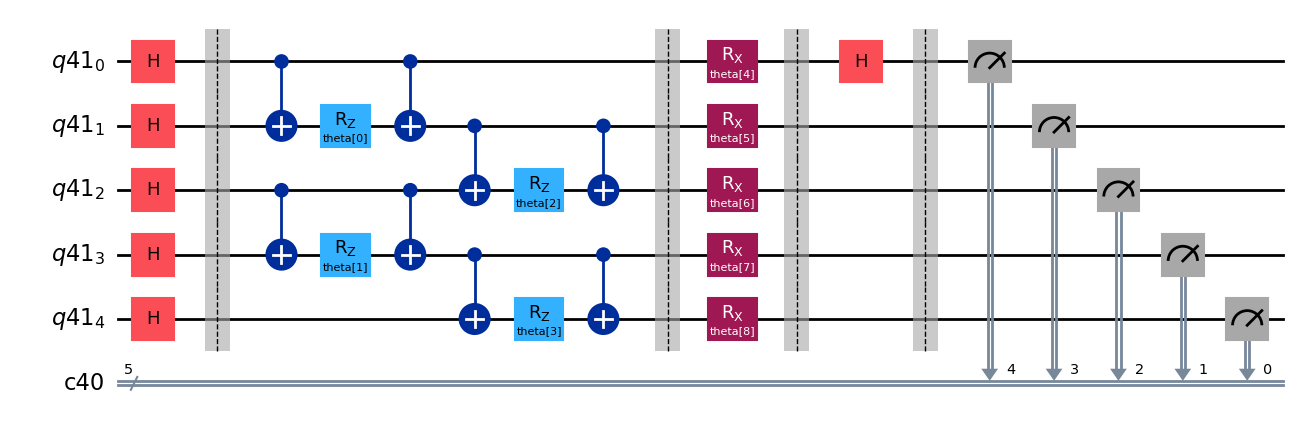

In [131]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

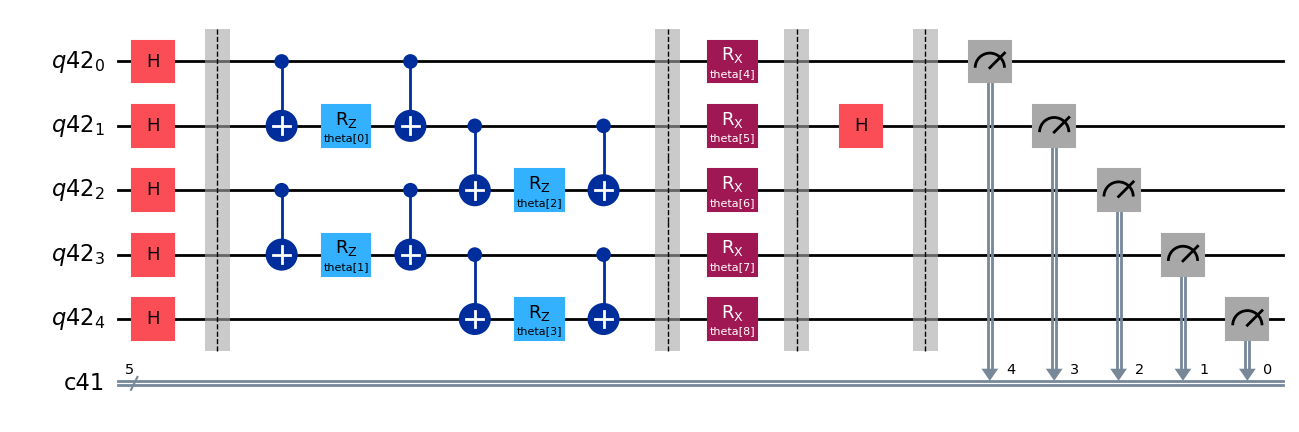

In [132]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

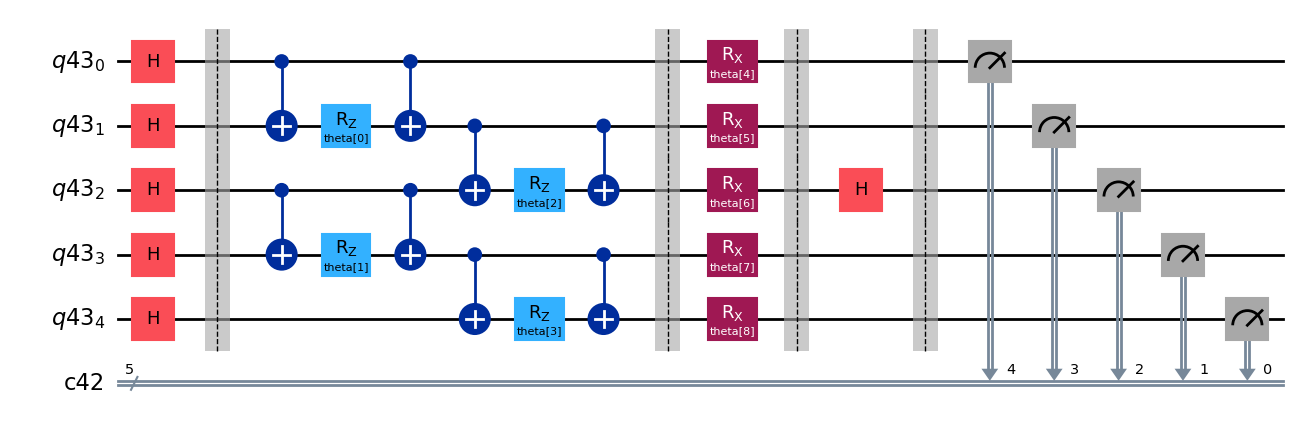

In [133]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

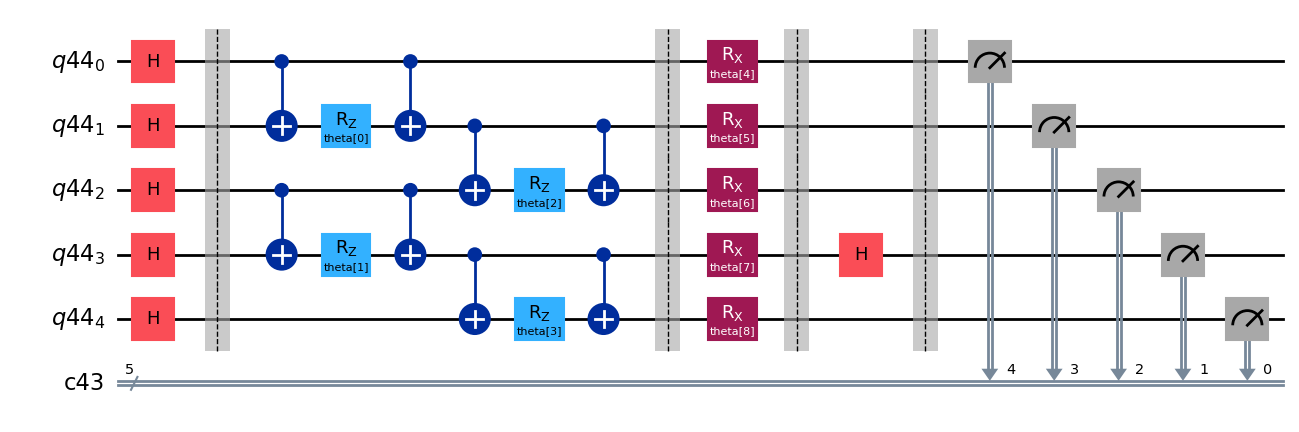

In [134]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

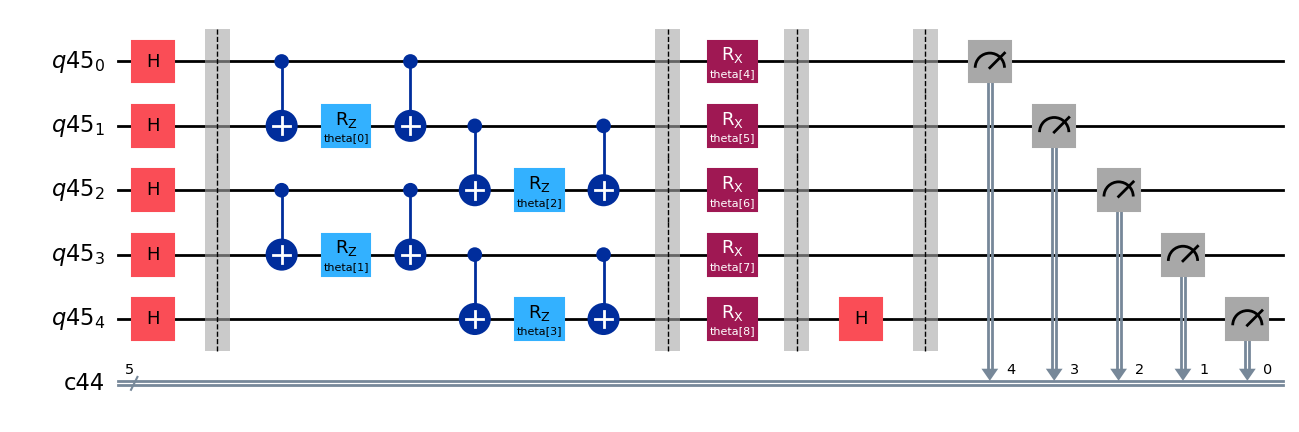

In [135]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

In [136]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## cost function

In [141]:
def ZZ(ansatz_zz, params_pqc, sampler, shots):
  transpiled_circuit = transpile(ansatz_zz, backend)
  job = backend.run(transpiled_circuit)
  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + counts[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - counts[k]

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + counts[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - counts[k]

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + counts[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - counts[k]

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + counts[k]
    else:
      expval = expval - counts[k]

  return expval

In [142]:
def X0(ansatz_x0, params_pqc, sampler, shots):


  transpiled_circuit = transpile(ansatz_zz, backend)

  transpiled_circuilt.measure_all()
  sampler = Sampler(backend)

  job = sampler.run([(transpiled_circuit)])

  result = job.result()[0]

  counts = result.data.meas.get_counts()









  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(16):
    delt = counts[k] - counts[k+16]
    expval = expval + delt

  return expval


def X1(ansatz_x1, params_pqc, sampler, shots):
  transpiled_circuit = transpile(ansatz_zz, backend)
  job = backend.run(transpiled_circuit)
  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(8):
    delt = counts[k] - counts[k+8]
    expval = expval + delt

  for k in range(16,24,1):
    delt = counts[k] - counts[k+8]
    expval = expval + delt

  return expval


def X2(ansatz_x2, params_pqc, sampler, shots):
  transpiled_circuit = transpile(ansatz_zz, backend)
  job = backend.run(transpiled_circuit)
  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(4):
    delt = counts[k] - counts[k+4]
    expval = expval + delt

  for k in range(8,12,1):
    delt = counts[k] - counts[k+4]
    expval = expval + delt

  for k in range(16,20,1):
    delt = counts[k] - counts[k+4]
    expval = expval + delt

  for k in range(24,28,1):
    delt = counts[k] - counts[k+4]
    expval = expval + delt

  return expval


def X3(ansatz_x3, params_pqc, sampler, shots):
  transpiled_circuit = transpile(ansatz_zz, backend)
  job = backend.run(transpiled_circuit)
  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(0,32,4):
    expval = expval + (counts[k] - counts[k+2])
    expval = expval + (counts[k+1] - counts[k+3])

  return expval


def X4(ansatz_x4, params_pqc, sampler, shots):
  transpiled_circuit = transpile(ansatz_zz, backend)
  job = backend.run(transpiled_circuit)
  counts = job.result().get_counts(shots)

  for i in range(32):
   if not (i in counts):  counts[i] = 0

  expval = 0

  for k in range(0,32,2):
    expval = expval + (counts[k] - counts[k+1])

  return expval

In [143]:
def cost_func_vqe(params_pqc, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots):
  expval = 0
  expval = expval + ZZ(ansatz_zz, params_pqc, sampler, shots)
  expval = expval - X0(ansatz_x0, params_pqc, sampler, shots)
  expval = expval - X1(ansatz_x1, params_pqc, sampler, shots)
  expval = expval - X2(ansatz_x2, params_pqc, sampler, shots)
  expval = expval - X3(ansatz_x3, params_pqc, sampler, shots)
  expval = expval - X4(ansatz_x4, params_pqc, sampler, shots)

  return expval/shots

In [144]:
shots = 1000

cost_func_vqe(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots)

AerError: 'circuits have parameters but parameter_binds is not specified.'

In [ ]:
def build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict):
  def callback(current_vector):
    callback_dict_vqe["iters"] += 1
    callback_dict_vqe["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots)

    callback_dict_vqe["cost_history"].append(current_cost_vqe)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])

x0

array([5.803e+00, 5.886e+00, 5.886e+00, 5.803e+00, 7.854e+00, 1.823e-07,
       7.854e+00, 1.749e-06, 1.571e+00])

In [ ]:
shots = 50
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.772
0.5209836849652784


In [ ]:
shots = 250
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.828
0.3568573944869295


In [ ]:
shots = 500
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.7392
0.2579128534990067


In [ ]:
shots = 750
lst = []
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.8792
0.19418094654213586


In [ ]:
shots = 1000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.888200000000001
0.17034036515165718


In [ ]:
shots = 2000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.880733333333334
0.1547022372890002


In [ ]:
shots = 5000
for i in range(10):
  callback_vqe = build_callback_vqe(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  lst.append(cost_func_vqe(res.x, ansatz_zz, ansatz_x0, ansatz_x1, ansatz_x2, ansatz_x3, ansatz_x4, sampler, shots))
print(np.mean(np.array(lst)))
print(2*np.sqrt(np.var(np.array(lst))))

-5.881
0.14154422630400695


# 6. Classical Shadow (Randomized Clifford Gates) 5Q Backend

In [ ]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Batch

from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate

## ansatz and classical shadow

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

def circuit_base(params, num_qubits):

  ansatz = QuantumCircuit(num_qubits)
  it = iter(params)
  ansatz.h(range(0,5))

  ansatz.barrier()

  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.rz(next(it), 1)
  ansatz.rz(next(it), 3)
  ansatz.cx(0, 1)
  ansatz.cx(2, 3)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)
  ansatz.rz(next(it), 2)
  ansatz.rz(next(it), 4)
  ansatz.cx(1, 2)
  ansatz.cx(3, 4)

  ansatz.barrier()

  ansatz.rx(next(it), 0)
  ansatz.rx(next(it), 1)
  ansatz.rx(next(it), 2)
  ansatz.rx(next(it), 3)
  ansatz.rx(next(it), 4)

  return ansatz

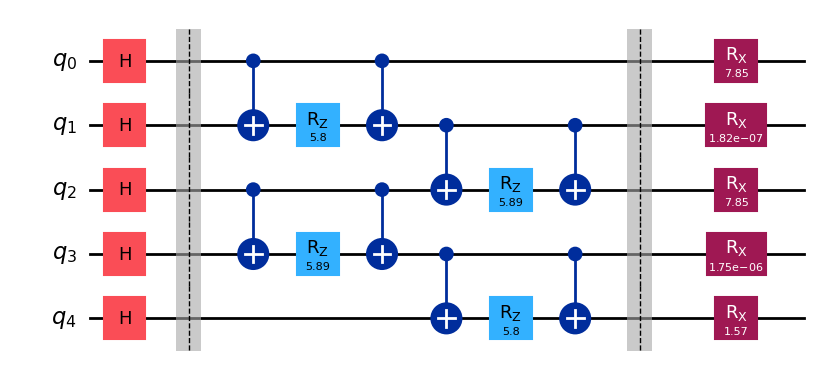

In [ ]:
%matplotlib inline

params = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])
qc = circuit_base(params, num_qubits)
qc.draw("mpl")

In [ ]:
pauli_list = [
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]

In [ ]:
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

In [ ]:
def cluster_rho(num_qubits, qc, size):

  reps = 1

  Cluster_Size = size
  cliffords = [qiskit.quantum_info.random_clifford(num_qubits) for _ in range(Cluster_Size)]

  results = []
  for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(1)
    results.append(counts)

  shadows = []
  for cliff, res in zip(cliffords, results):
    mat = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(num_qubits,np.outer(Ub,Ub.conj()))*count)

  return np.sum(shadows,axis=0)/(Cluster_Size)

In [ ]:
def generate_pauli_string(location, pauli, num_qubits):
    string = ["I"] * num_qubits
    for i, loc in enumerate(location):
        string[num_qubits-loc-1] = pauli[i]

    result = ''.join(char for char in string)

    return result

In [ ]:
list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  +[SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)])

In [ ]:
def clustor_observable(num_qubits, qc, size, list_of_observables):
  lst = []
  for o in list_of_observables:
    rho = cluster_rho(num_qubits, qc, size)
    o_matrix = o.to_matrix()
    lst.append(np.real(np.trace(np.matmul(rho, o_matrix))))

  lst = np.array(lst)

  return lst

In [ ]:
qc = circuit_base(params, num_qubits)
print(clustor_observable(num_qubits, qc, 200, list_of_observables))

[-4.95000000e-01 -4.95000000e-01 -1.65000000e-01 -1.65000000e-01
  8.25000000e-01  6.60000000e-01  1.48500000e+00  8.25000000e-01
  2.49800181e-16]


In [ ]:
def mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, size=200):
  qc = circuit_base(params, num_qubits)
  median_list = []

  sum = 0

  observable_list = []
  for i in range(shadow_size//200):
    observable_list.append(clustor_observable(num_qubits, qc, 200, list_of_observables))

  for j in range(9):
    med = np.median(np.array([observable_list[i][j] for i in range(shadow_size//200)]))

    if j<4:
      sum = sum + med

    else:
      sum = sum - med

  return sum

## cost function

In [ ]:
def cost_func_clifford_shadow(params, shadow_size):
  num_qubits = 5
  list_of_observables = ([SparsePauliOp(generate_pauli_string([i,i+1],["Z","Z"], num_qubits)) for i in range(num_qubits - 1)]  +[SparsePauliOp(generate_pauli_string([i],["X"], num_qubits)) for i in range(num_qubits)])
  return mean_hamiltonian(num_qubits, params, list_of_observables, shadow_size, 200)

In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 200))

-5.609999999999992
-5.609999999999992
-5.279999999999991
-5.279999999999991
-11.219999999999986
-11.219999999999986
-5.279999999999992
-5.279999999999992
-5.609999999999991
-5.609999999999991
-3.299999999999995
-3.299999999999995
-3.2999999999999954
-3.2999999999999954
-5.93999999999999
-5.93999999999999
-6.269999999999992
-6.269999999999992
-4.289999999999994
-4.289999999999994


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 250))

-5.675999999999993
-5.675999999999993
-4.883999999999997
-4.883999999999997
-6.071999999999996
-6.071999999999996
-8.579999999999995
-8.579999999999995
-6.467999999999992
-6.467999999999992
-6.335999999999992
-6.335999999999992
-6.467999999999996
-6.467999999999996
-6.203999999999992
-6.203999999999992
-4.091999999999993
-4.091999999999993
-7.655999999999993
-7.655999999999993


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 500))

-4.421999999999995
-4.421999999999995
-7.127999999999994
-7.127999999999994
-6.138000000000002
-6.138000000000002
-6.929999999999998
-6.929999999999998
-4.949999999999996
-4.949999999999996
-6.8639999999999946
-6.8639999999999946
-5.741999999999994
-5.741999999999994
-6.4019999999999975
-6.4019999999999975
-5.214
-5.214
-6.665999999999997
-6.665999999999997


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 750))

-6.512000000000002
-6.512000000000002
-5.280000000000004
-5.280000000000004
-5.412000000000003
-5.412000000000003
-6.072000000000001
-6.072000000000001
-5.808000000000001
-5.808000000000001
-4.532000000000003
-4.532000000000003
-6.028
-6.028
-6.556000000000001
-6.556000000000001
-6.731999999999996
-6.731999999999996
-4.928000000000004
-4.928000000000004


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 1000))

-5.016000000000002
-5.016000000000002
-5.808000000000004
-5.808000000000004
-5.247000000000005
-5.247000000000005
-5.610000000000006
-5.610000000000006
-6.204000000000002
-6.204000000000002
-6.237
-6.237
-6.930000000000005
-6.930000000000005
-6.171000000000002
-6.171000000000002
-5.907000000000003
-5.907000000000003
-6.336000000000001
-6.336000000000001


In [ ]:
for _ in range(10):
  print(cost_func_clifford_shadow(np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00]), 2000))

-6.517500000000012
-6.517500000000012
-5.49450000000001
-5.49450000000001
-5.907000000000008
-5.907000000000008
-6.303000000000004
-6.303000000000004
-5.973000000000006
-5.973000000000006
-6.3855000000000075
-6.3855000000000075
-6.138000000000009
-6.138000000000009
-5.824500000000005
-5.824500000000005
-6.055500000000013
-6.055500000000013
-5.973000000000011
-5.973000000000011


In [ ]:
lst = [-5.609999999999992,
-5.279999999999991,
-11.219999999999986,
-5.279999999999992,
-5.609999999999991,
-3.299999999999995,
-3.2999999999999954,
-5.93999999999999,
-6.269999999999992,
-4.289999999999994]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-5.675999999999993,
-4.883999999999997
-6.071999999999996
-8.579999999999995,
-6.467999999999992,
-6.335999999999992,
-6.467999999999996,
-6.203999999999992,
-4.091999999999993,
-7.655999999999993]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-4.421999999999995,
-7.127999999999994,
-6.138000000000002,
-6.929999999999998,
-4.949999999999996,
-6.8639999999999946,
-5.741999999999994,
-6.4019999999999975,
-5.214,
-6.665999999999997]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-6.512000000000002,
-5.280000000000004,
-5.412000000000003,
-6.072000000000001,
-5.808000000000001,
-4.532000000000003,
-6.028,
-6.556000000000001,
-6.731999999999996,
-4.928000000000004]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-5.016000000000002,
-5.808000000000004,
-5.247000000000005,
-5.610000000000006,
-6.204000000000002,
-6.237,
-6.930000000000005,
-6.171000000000002,
-5.907000000000003,
-6.336000000000001]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()


lst = [-6.517500000000012,
-5.49450000000001,
-5.907000000000008,
-6.303000000000004,
-5.973000000000006,
-6.3855000000000075,
-6.138000000000009,
-5.824500000000005,
-6.055500000000013,
-5.973000000000011]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))
print()

-5.609999999999991
2.113030998352838

-7.804499999999992
4.531195620363348

-6.045599999999996
0.8811432573651118

-5.786000000000002
0.697160526708159

-5.946600000000003
0.5300173959409255

-6.057150000000009
0.2818024174843076



In [ ]:
lst = [-5.016000000000002,
-5.808000000000004,
-5.247000000000005,
-5.610000000000006,
-6.204000000000002,
-6.237,
-6.930000000000005,
-6.171000000000002,
-5.907000000000003,
-6.336000000000001]

lst = np.array(lst)
print(np.mean(lst))
print(np.sqrt(np.var(lst)))

# 번외

In [ ]:
def build_callback_clifford_shadow(size, callback_dict):
  def callback(current_vector):
    callback_dict_clifford_shadow["iters"] += 1
    callback_dict_clifford_shadow["prev_vector"] = current_vector
    current_cost_clifford_shadow = cost_func_clifford_shadow(current_vector, size)

    callback_dict_clifford_shadow["cost_history"].append(current_cost_clifford_shadow)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict_clifford_shadow["iters"], current_cost_clifford_shadow),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict_clifford_shadow = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

options = dict()
options["maxiter"] = 50000
options["disp"] = True

np.random.seed(4)
x0 = np.array([5.803e+00,  5.886e+00,  5.886e+00,  5.803e+00,  7.854e+00, 1.823e-07,  7.854e+00,  1.749e-06,  1.571e+00])

x0

array([5.803e+00, 5.886e+00, 5.886e+00, 5.803e+00, 7.854e+00, 1.823e-07,
       7.854e+00, 1.749e-06, 1.571e+00])

In [ ]:
size = 1000

callback_clifford_shadow = build_callback_clifford_shadow(size, callback_dict_clifford_shadow)
res = minimize(
  cost_func_clifford_shadow,
  x0,
  args=(size),
  method="bfgs",
  callback=callback_vqe,
  options=options
)

-4.983000000000006
-5.412000000000006
-6.765000000000004
-6.204000000000006
-6.566999999999997


In [ ]:
-5.675999999999991

In [ ]:
size = 200

rho_list = []
"""
for i in range(size//200):
  rho_list.append([])

print(rho_list)
"""
for i in range(size//200):
  rho = cluster_rho(num_qubits, qc)

  for j in range(9):
    coeff_list = [0,0,0,0,0,0,0,0,0]
    coeff_list[i]=1

    operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]

    hamiltonian_list = []

    for i in range(9):
      hamiltonian_list.append((operator_list[i], coeff_list[i]))

    hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
    hamiltonian_matrix = hamiltonian.to_matrix()

    rho_list.append(np.trace(np.matmul(rho, hamiltonian_matrix)))


In [ ]:
rho_list

In [ ]:
from qiskit.quantum_info import SparsePauliOp

interation = 1
bias = -1

sum = 0
for i in range(9):
  coeff_list = [0,0,0,0,0,0,0,0,0]
  coeff_list[i]=1

  operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]

  hamiltonian_list = []
  for i in range(9):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
  hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
  hamiltonian_matrix = hamiltonian.to_matrix()

  nlist = []
  for i in range(100):
    nlist.append(np.trace(np.matmul(cluster_rho(num_qubits, qc), hamiltonian_matrix)))

  nlist = np.array(nlist)
  print(np.median(nlist))

  if i<4:
    sum = sum + np.median(nlist)
  else:
    sum = sum - np.median(nlist)

In [ ]:
med = np.median(np.array(nlist))

print(med)

In [ ]:
def shadow_bound(error, observables, failure_rate=0.01):
    """
    Calculate the shadow bound for the Pauli measurement scheme.

    Implements Eq. (S13) from https://arxiv.org/pdf/2002.08953.pdf

    Args:
        error (float): The error on the estimator.
        observables (list) : List of matrices corresponding to the observables we intend to
            measure.
        failure_rate (float): Rate of failure for the bound to hold.

    Returns:
        An integer that gives the number of samples required to satisfy the shadow bound and
        the chunk size required attaining the specified failure rate.
    """
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = lambda op: np.linalg.norm(op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf) ** 2
    N = 34 * max(shadow_norm(o) for o in observables) / error**2
    return int(np.ceil(N * K)), int(K)

# 2Q~5Q VQE Lowest Energy

## 5 qubits Varation

In [127]:
import matplotlib.pyplot as plt

x = [100, 250, 500, 750, 1000, 2000, 5000]

y = [-5.18, -5.408, -5.652, -5.7253, -5.47, -5.74, -5.7836]
yerr = [1.828, 1.94279, 0.7539, 0.81376, 0.37619, 0.6989, 0.29388]

#z = [-5.610, -7.8045, -6.04559, -5.786, -5.9466, -6.057]
#zerr = [2*2.113030998352838, 2*4.531195620363348, 2*0.8811432573651118, 2*0.697160526708159, 2*0.5300173959409255, 2*0.2818024174843076]

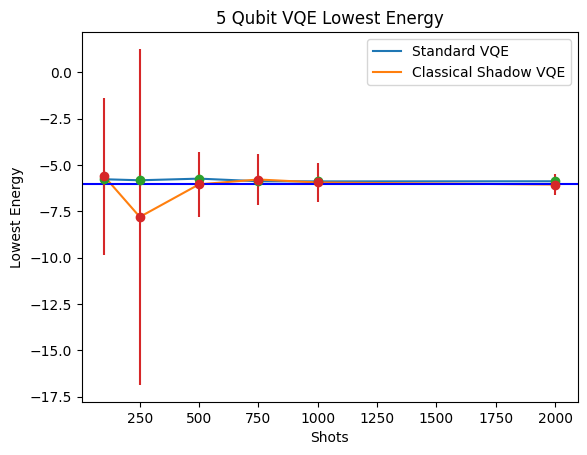

In [ ]:
plt.plot(x, y, label="Standard VQE")
plt.plot(x, z, label="Classical Shadow VQE")
plt.axhline(y=-7.7888, xmin=0, xmax=2000, color='blue', linestyle='solid')
plt.errorbar(x, y, yerr=yerr, fmt ='o')
plt.errorbar(x, z, yerr=zerr, fmt ='o')

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

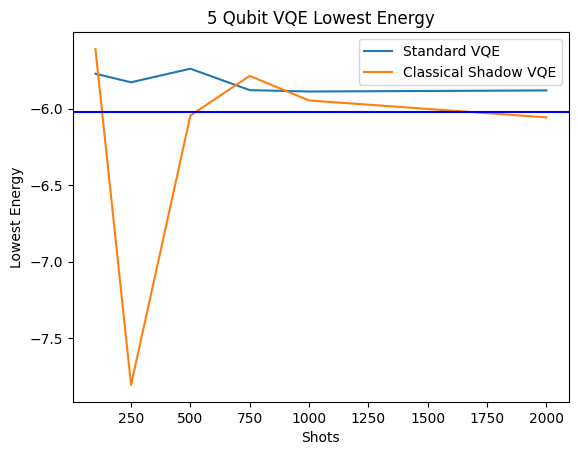

In [ ]:
plt.plot(x, y, label="Standard VQE")
plt.plot(x, z, label="Classical Shadow VQE")
plt.axhline(y=-7.7888, xmin=0, xmax=2000, color='blue', linestyle='solid')

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

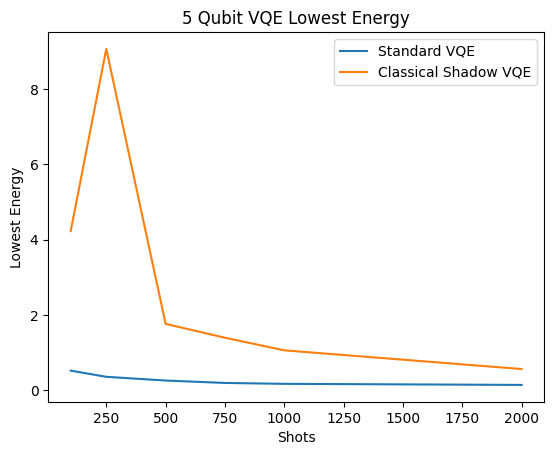

In [ ]:
plt.plot(x, yerr, label="Standard VQE")
plt.plot(x, zerr, label="Classical Shadow VQE")

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

참값과의 차이 / error 바 크기

둘 다 shot 늘어나면 exact하게 간다
-> error바 줄어들고, 참값과의 차이도

total measurement 횟수 measurement circuit을 다 일일히 만들고,



## 5 qubits

In [ ]:
import matplotlib.pyplot as plt

x = [100, 250, 500, 750, 1000, 2000, 5000]

y = [-5.772, -5.828, -5.7392, -5.8792, -5.8882, -5.881, -5.881,]
yerr = [0.52098, 0.35685, 0.25791, 0.19418, 0.17034, 0.14154, 0.141544]

z = [-5.610, -7.8045, -6.04559, -5.786, -5.9466, -6.057, -6.025]
zerr = [2*2.113030998352838, 2*4.531195620363348, 2*0.8811432573651118, 2*0.697160526708159, 2*0.5300173959409255, 2*0.2818024174843076, 2*0.2318024174843076]

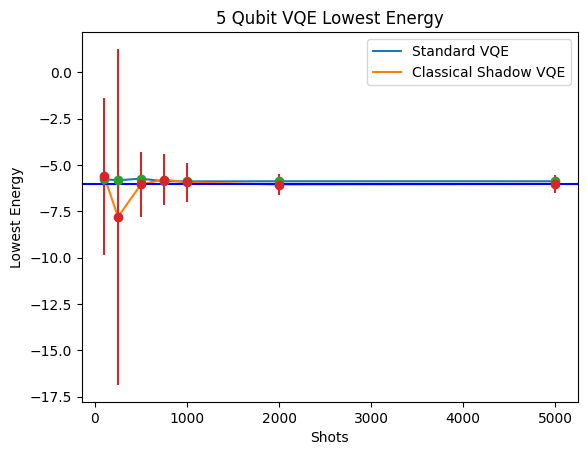

In [ ]:
plt.plot(x, y, label="Standard VQE")
plt.plot(x, z, label="Classical Shadow VQE")
plt.axhline(y=-6.02, xmin=0, xmax=2000, color='blue', linestyle='solid')
plt.errorbar(x, y, yerr=yerr, fmt ='o')
plt.errorbar(x, z, yerr=zerr, fmt ='o')

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

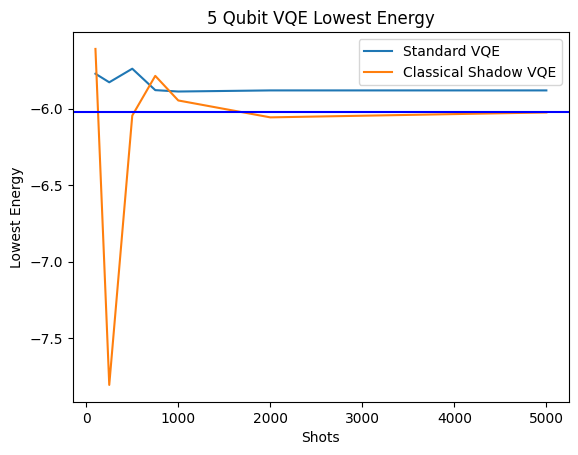

In [ ]:
plt.plot(x, y, label="Standard VQE")
plt.plot(x, z, label="Classical Shadow VQE")
plt.axhline(y=-6.02, xmin=0, xmax=2000, color='blue', linestyle='solid')

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

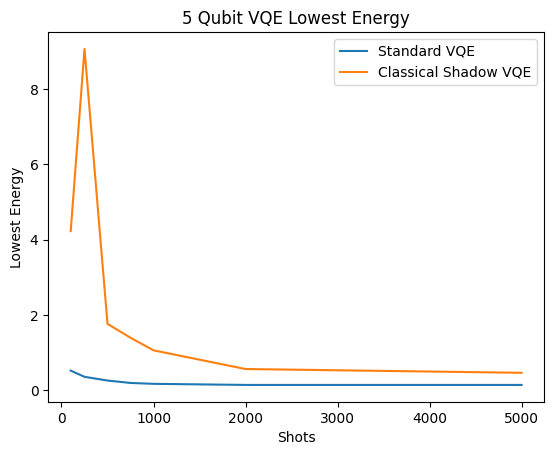

In [ ]:
plt.plot(x, yerr, label="Standard VQE")
plt.plot(x, zerr, label="Classical Shadow VQE")

plt.legend()
plt.xlabel('Shots')
plt.ylabel('Lowest Energy')
plt.title("5 Qubit VQE Lowest Energy")
plt.show()

참값과의 차이 / error 바 크기

둘 다 shot 늘어나면 exact하게 간다
-> error바 줄어들고, 참값과의 차이도

total measurement 횟수 measurement circuit을 다 일일히 만들고,

